In [2]:
# %matplotlib ipympl

In [7]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")

hostname = os.uname()
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

plt.style.use('default')


In [8]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



#### Import Datasets

In [9]:
DataPath = os.path.abspath('../Data/Processed/')
print('DataPath:',DataPath)

DataPath: /remote/tychodata/ftairli/work/CDEs/Data/Processed


In [10]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1: # pyright: ignore[reportUndefinedVariable]
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces) # pyright: ignore[reportUndefinedVariable]
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys(): # pyright: ignore[reportPossiblyUnboundVariable]
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2') # type: ignore
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2') # pyright: ignore[reportPossiblyUnboundVariable]
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Dataset already loaded
Dataset Event_level_keys is None, reloading Dataset
Loading CDEsDataset
EventID Keys already replaced


In [11]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [12]:
AllPossiblePixelDirections = pd.read_csv('../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [13]:
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


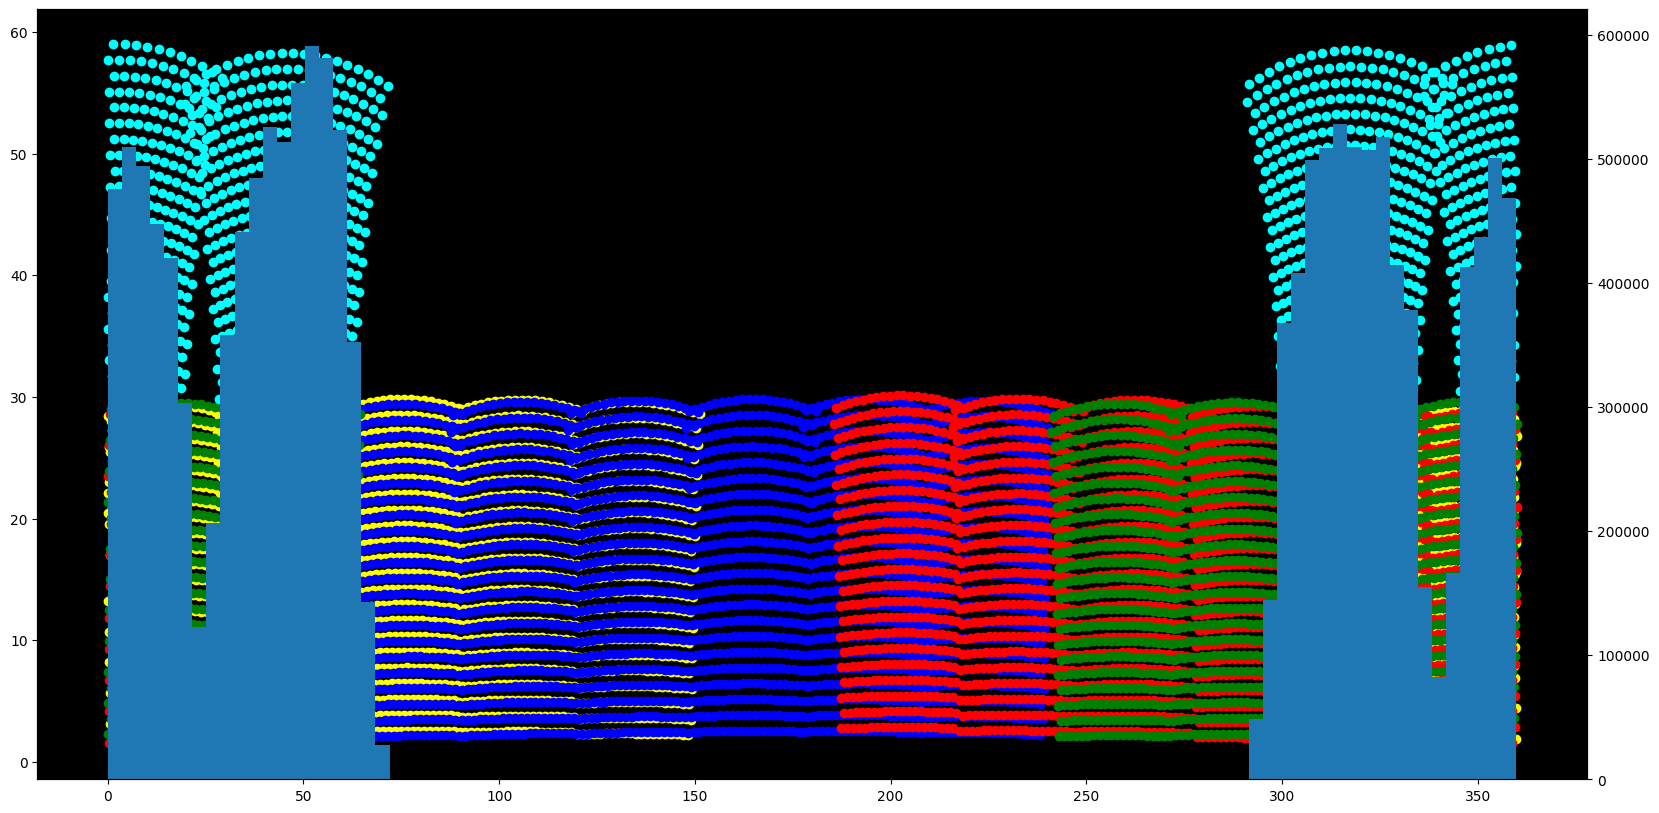

In [14]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = (20,10))
plt.gca().set_facecolor('black')
for iEye in range(1,6):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    
ax2 = plt.gca().twinx()
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0
AllThetas = Dataset.get_pixel_values('Theta')
# plt.hist(AllThetas,bins=100)
AllPhis   = Dataset.get_pixel_values('Phi')
X = AllPhis+HE_BackwallAngle
X[X>360] -= 360
ax2.hist(X,bins=100)
plt.show()

In [15]:
event_class_labels = {
    0: 'Shower Candidate',
    1: 'Close Shower',
    2: 'Horizontal Shower',
    3: 'Large Event',
    4: 'Muon + Noise',
    5: 'Long Muon',
    6: 'Noise',
    7: 'Muon'
}

In [16]:
All_Event_Classes = Dataset.get_values('Event_Class').numpy()

for i in range(8):
    mask = All_Event_Classes == i
    print(f'Event Class {event_class_labels[i]} : {(np.sum(mask)/len(mask)*100):.3f} % events')

Event Class Shower Candidate : 10.114 % events
Event Class Close Shower : 32.292 % events
Event Class Horizontal Shower : 0.590 % events
Event Class Large Event : 0.001 % events
Event Class Muon + Noise : 36.433 % events
Event Class Long Muon : 11.020 % events
Event Class Noise : 1.445 % events
Event Class Muon : 8.103 % events


#### Testing a re-triggering mechanism

In [12]:
for event in Dataset:
    Event = event
    break

In [13]:
Traces = Event.get_trace_values()
print(f'Shape of traces: {Traces.shape}')
# plt.figure(figsize = [20,10])
for trace in Traces:
    # Calculate variance of each trace
    variance = torch.var(trace[-30:])
    print(variance)

Shape of traces: torch.Size([62, 40])
tensor(72.5430)
tensor(87.2469)
tensor(111.9660)
tensor(199.5637)
tensor(200.8684)
tensor(61.2157)
tensor(278.7889)
tensor(25.0803)
tensor(190.7764)
tensor(31.4729)
tensor(154.6127)
tensor(14.5968)
tensor(237.8211)
tensor(313.0544)
tensor(89.7963)
tensor(31.0692)
tensor(4.9014)
tensor(19.6858)
tensor(159.8039)
tensor(139.9006)
tensor(53.2543)
tensor(5.6091)
tensor(19.4787)
tensor(116.5578)
tensor(1403.1284)
tensor(150.1687)
tensor(60.4422)
tensor(117.9351)
tensor(92.1221)
tensor(105.6887)
tensor(236.1996)
tensor(98.9701)
tensor(443.9908)
tensor(105.5331)
tensor(38.4980)
tensor(96.1906)
tensor(93.6682)
tensor(10.4385)
tensor(191.2502)
tensor(36.3561)
tensor(9.6557)
tensor(69.4792)
tensor(271.8373)
tensor(137.5635)
tensor(1.5477)
tensor(279.5806)
tensor(5.1114)
tensor(240.3090)
tensor(125.2913)
tensor(117.3462)
tensor(323.0947)
tensor(46.3484)
tensor(31.1079)
tensor(73.9626)
tensor(403.4248)
tensor(56.6976)
tensor(84.8082)
tensor(101.2164)
tensor(46.

In [14]:
All_Duration = []
All_CherenkovFraction = []

for Event in Dataset:
    Cherenkov_Fraction = Event.get_value('Gen_CherenkovFraction').item()
    
    Event_pix_status = Event.get_pixel_values('Status')
    if torch.sum(Event_pix_status == 4) < 2: continue
    Event_pix_TelIDS = Event.get_pixel_values('TelID')
    Unique_TelIDs = torch.unique(Event_pix_TelIDS[Event_pix_status==4])
    if len(Unique_TelIDs) > 1: continue
    Event_pix_pulse_start = Event.get_pixel_values('PulseStart') [Event_pix_status==4] 
    Event_pix_pulse_stop  = Event.get_pixel_values('PulseStop')  [Event_pix_status==4]

    Event_Duration = torch.max(Event_pix_pulse_stop) - torch.min(Event_pix_pulse_start)
    if not Unique_TelIDs.item() in [1,2,3,4,5,6]: Event_Duration = Event_Duration/2
    
    All_Duration.append(Event_Duration.item())
    All_CherenkovFraction.append(Cherenkov_Fraction)

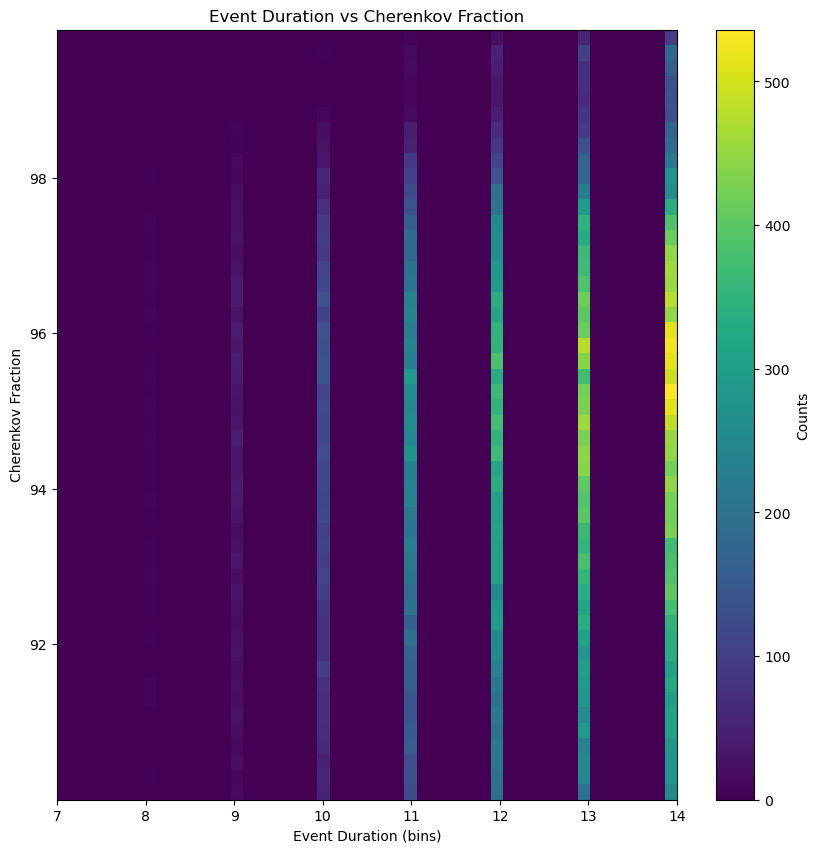

In [15]:
Cut = (np.array(All_Duration)<15) & (np.array(All_CherenkovFraction)>90)

X = np.array(All_Duration)[Cut]
Y = np.array(All_CherenkovFraction)[Cut]

plt.figure(figsize = (10,10))
plt.hist2d(X,Y,bins=50)
plt.colorbar(label='Counts')
plt.xlabel('Event Duration (bins)')
plt.ylabel('Cherenkov Fraction')
plt.title('Event Duration vs Cherenkov Fraction')
plt.show()

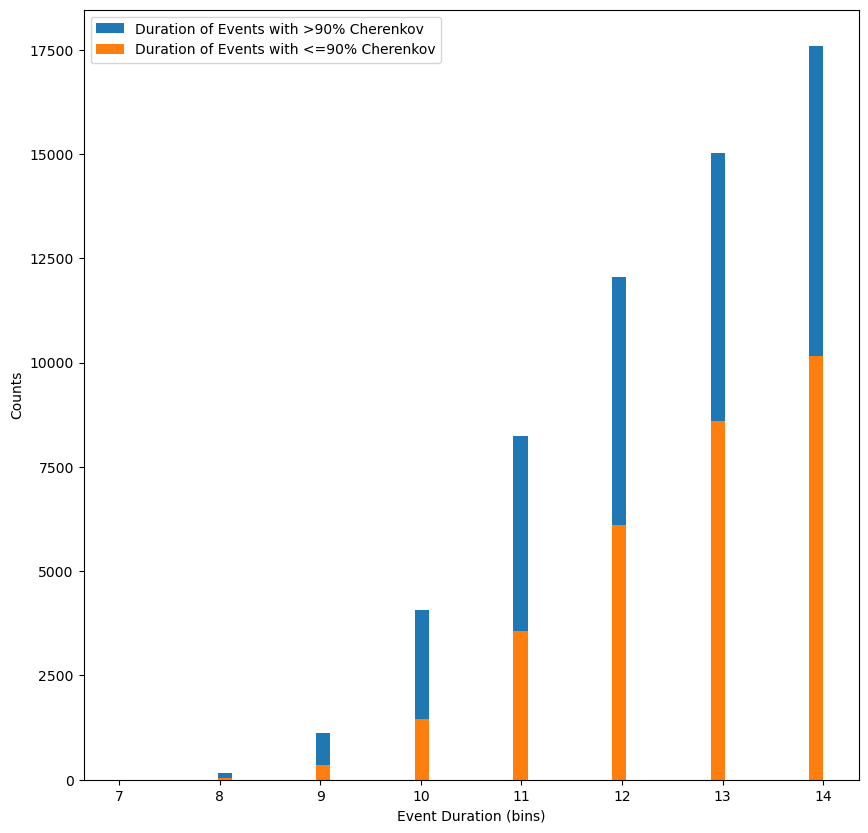

In [16]:
Cut = np.array(All_Duration)<15
X = np.array(All_Duration)[Cut]
Y = np.array(All_CherenkovFraction)[Cut]

Mask = Y>90

plt.figure(figsize = (10,10))
plt.hist(X[Mask],bins=50, label='Duration of Events with >90% Cherenkov')
plt.hist(X[~Mask],bins=50, label='Duration of Events with <=90% Cherenkov')
plt.xlabel('Event Duration (bins)')
plt.ylabel('Counts')
plt.legend()
plt.show()

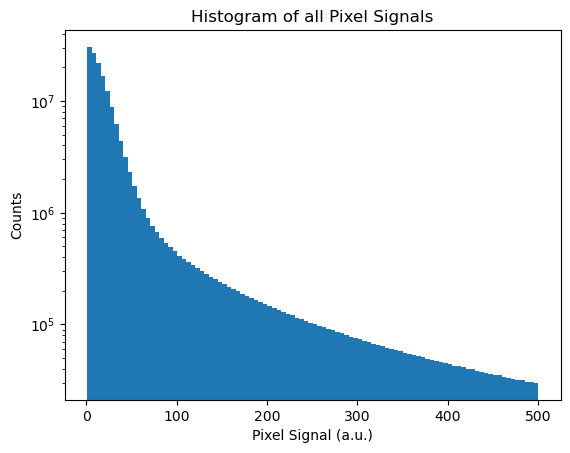

In [17]:

All_Signals = Dataset.get_trace_values().numpy()

plt.hist(All_Signals.flatten(),bins=100,range=(1,500),log=True)
plt.xlabel('Pixel Signal (a.u.)')
plt.ylabel('Counts')
plt.title('Histogram of all Pixel Signals')
plt.show()

#### Cherenkov Fraction vs Saturated Events


In [26]:
All_CherenkovFraction = []
All_N_HighSignal_Pixels = []
All_N_Total_Pulsed_Pixels = []
All_Gen_Rp   = []
All_Gen_Chi0 = []
High_Signal_Threshold = 15000

N_Events = len(Dataset)
for i,event in enumerate(Dataset):
    if i % 1000 == 0: print(f'Processing event {i}/{N_Events}', end = '\r')
    All_CherenkovFraction.append(event.get_value('Gen_CherenkovFraction'))
    All_Gen_Rp           .append(event.get_value('Gen_Rp'))
    All_Gen_Chi0         .append(event.get_value('Gen_Chi0'))
    event_Traces = event.get_trace_values()
    
    All_N_Total_Pulsed_Pixels.append(torch.sum(event.get_pixel_values('Status')==4).item())

    # Check the number of pixels that have a trace value over the threshold
    Pixel_Has_value_over_threshold = event_Traces > High_Signal_Threshold
    Pixel_Has_value_over_threshold = torch.sum(Pixel_Has_value_over_threshold, dim=1)
    N_Pixels_value_over_threshold  = torch.sum(Pixel_Has_value_over_threshold > 0).item()
    All_N_HighSignal_Pixels.append(N_Pixels_value_over_threshold)

    # break

All_CherenkovFraction     = np.array(All_CherenkovFraction)
All_N_HighSignal_Pixels   = np.array(All_N_HighSignal_Pixels)
All_N_Total_Pulsed_Pixels = np.array(All_N_Total_Pulsed_Pixels)

All_Gen_Rp              = np.array(All_Gen_Rp)
All_Gen_Chi0            = np.array(All_Gen_Chi0)

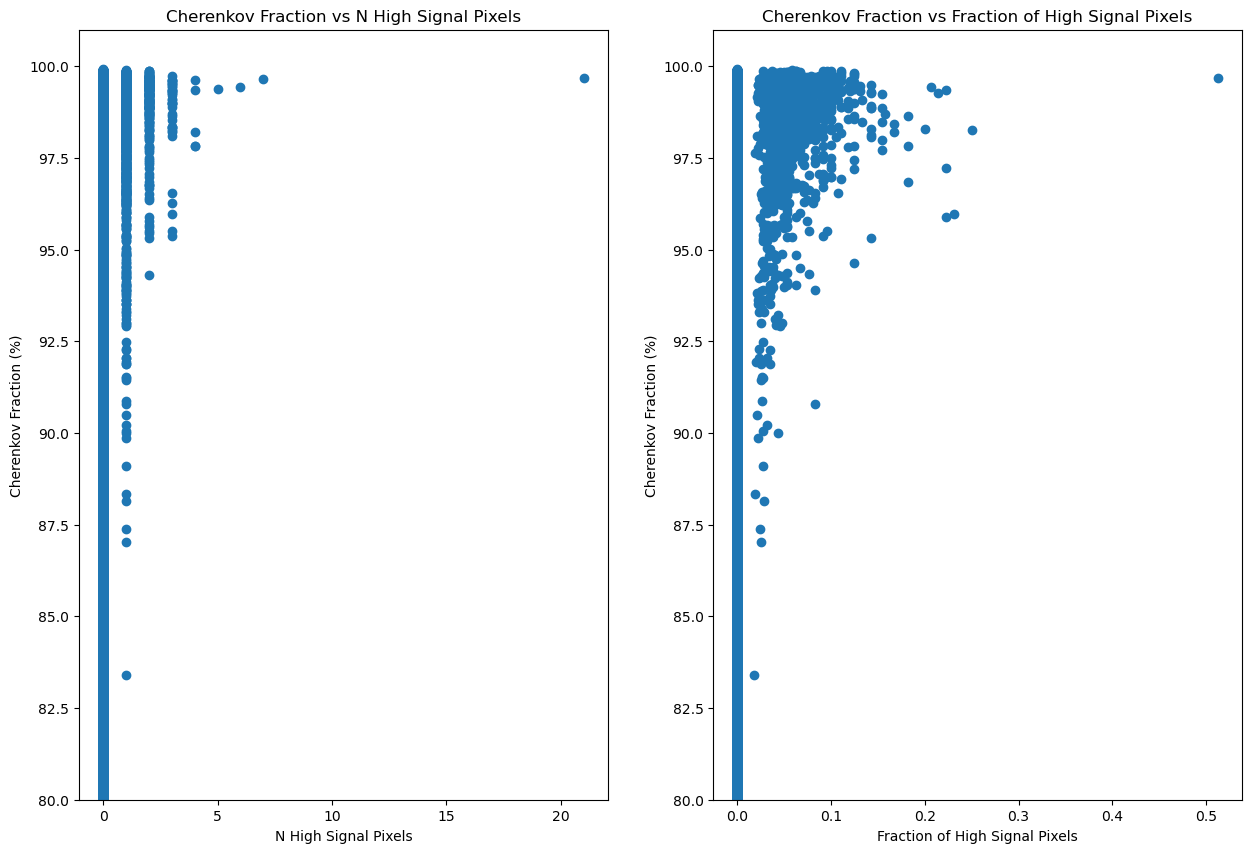

In [27]:
# Plot Cherenkov Fraction vs N High Signal Pixels
fig, ax = plt.subplots(1,2,figsize = (15,10))
ax[0].scatter(All_N_HighSignal_Pixels,All_CherenkovFraction)
ax[0].set_ylim(80,101)
ax[0].set_xlabel('N High Signal Pixels')
ax[0].set_ylabel('Cherenkov Fraction (%)')
ax[0].set_title('Cherenkov Fraction vs N High Signal Pixels')

ax[1].scatter(All_N_HighSignal_Pixels/All_N_Total_Pulsed_Pixels,All_CherenkovFraction)
ax[1].set_ylim(80,101)
ax[1].set_xlabel('Fraction of High Signal Pixels')
ax[1].set_ylabel('Cherenkov Fraction (%)')
ax[1].set_title('Cherenkov Fraction vs Fraction of High Signal Pixels')

plt.show()

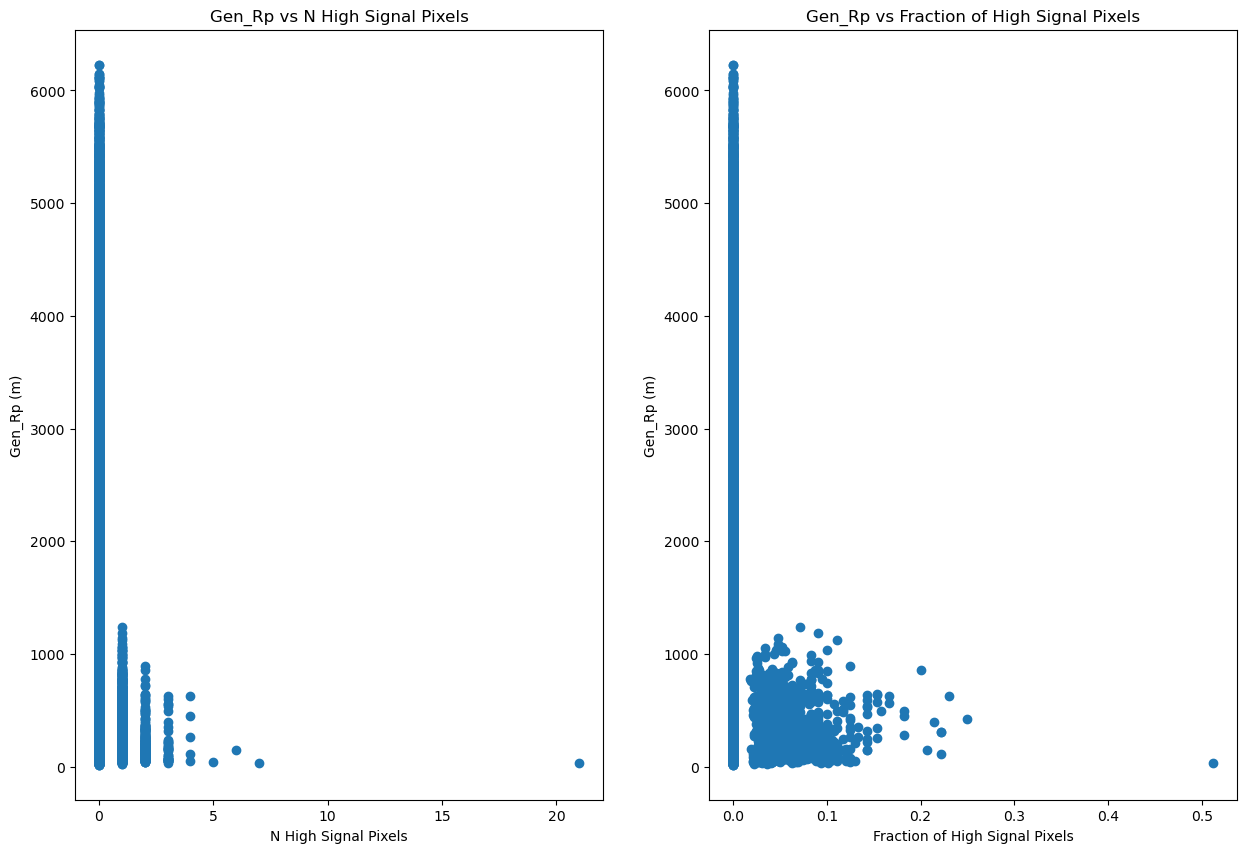

In [28]:
# Plot Gen_Rp vs N High Signal Pixels
fig, ax = plt.subplots(1,2,figsize = (15,10))
ax[0].scatter(All_N_HighSignal_Pixels,All_Gen_Rp)
ax[0].set_xlabel('N High Signal Pixels')
ax[0].set_ylabel('Gen_Rp (m)')
ax[0].set_title('Gen_Rp vs N High Signal Pixels')

ax[1].scatter(All_N_HighSignal_Pixels/All_N_Total_Pulsed_Pixels,All_Gen_Rp)
ax[1].set_xlabel('Fraction of High Signal Pixels')
ax[1].set_ylabel('Gen_Rp (m)')
ax[1].set_title('Gen_Rp vs Fraction of High Signal Pixels')

plt.show()

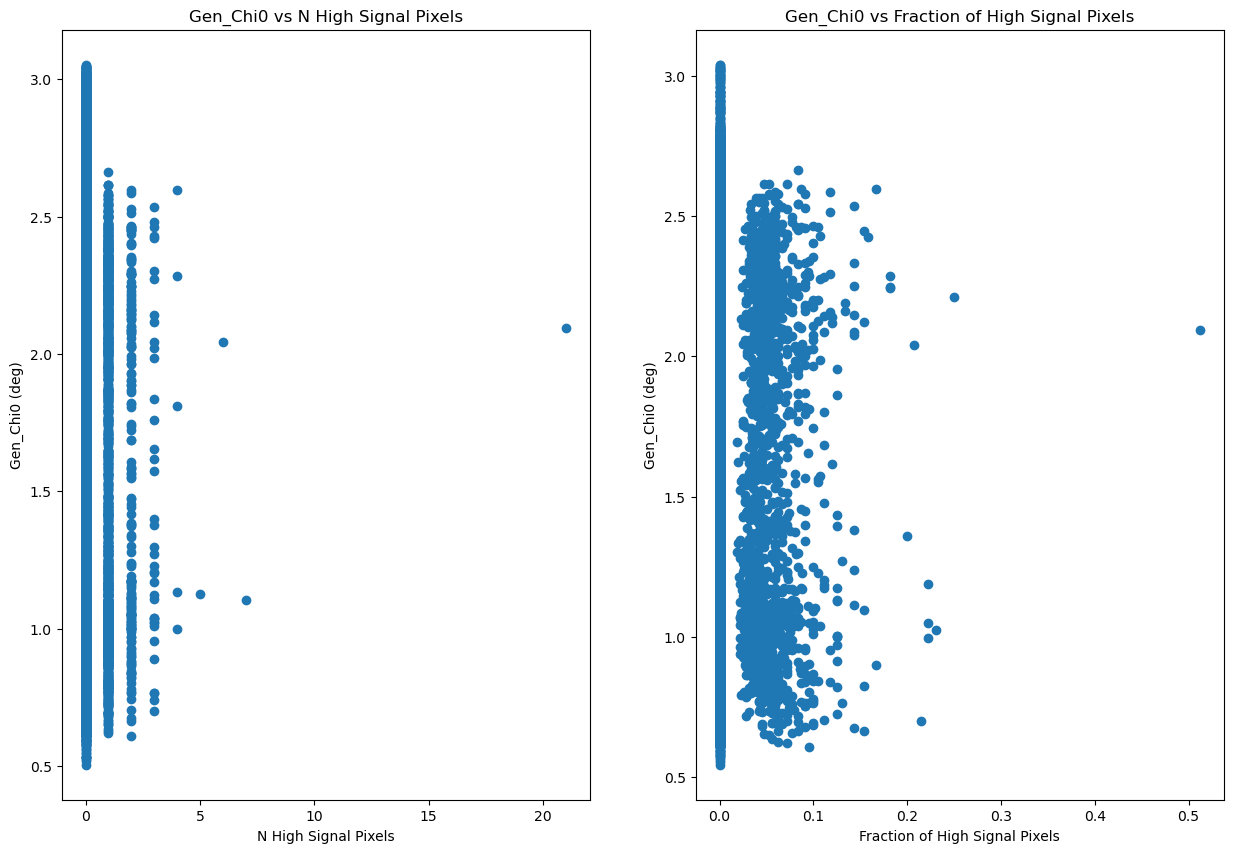

In [ ]:
# Plot Gen_Chi0 vs N High Signal Pixels
fig, ax = plt.subplots(1,2,figsize = (15,10))
ax[0].scatter(All_N_HighSignal_Pixels,All_Gen_Chi0)
ax[0].set_xlabel('N High Signal Pixels')
ax[0].set_ylabel('Gen_Chi0 (deg)')
ax[0].set_title('Gen_Chi0 vs N High Signal Pixels')

ax[1].scatter(All_N_HighSignal_Pixels/All_N_Total_Pulsed_Pixels,All_Gen_Chi0)
ax[1].set_xlabel('Fraction of High Signal Pixels')
ax[1].set_ylabel('Gen_Chi0 (deg)')
ax[1].set_title('Gen_Chi0 vs Fraction of High Signal Pixels')

plt.show()

#### Trying to figure out how to calculate pixel centroid

Number of traces of interest: 3569753


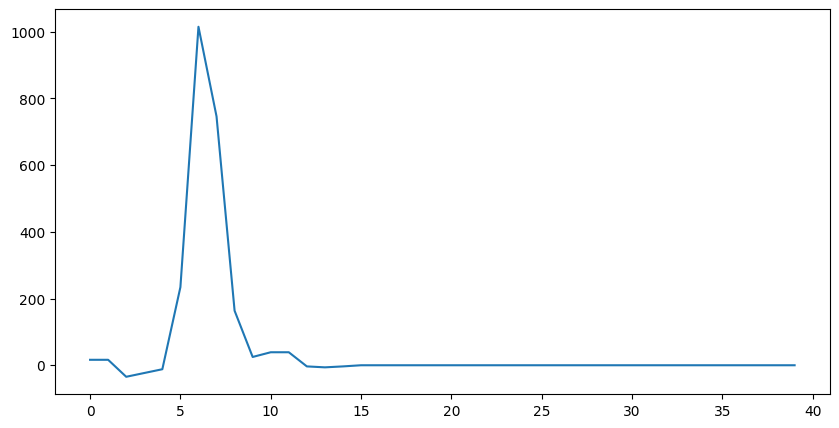

In [18]:
# Find Random Pixel Trace
All_Traces = Dataset.get_trace_values().numpy()
All_Status = Dataset.get_pixel_values('Status').numpy()

Mask = All_Status == 4
Traces_Of_Interest = All_Traces[Mask]
print(f'Number of traces of interest: {len(Traces_Of_Interest)}')


N = np.random.randint(0,len(Traces_Of_Interest))

Trace = Traces_Of_Interest[N]
plt.figure(figsize = (10,5))
plt.plot(Trace)
